# Notebook structure

1. Preparing data <br>
__1.1 Standardize <br>
__1.2 Shaping <br>
2. Building models
3. Evaluate on Test data
4. Make submission
---
- You can train new models and make a submission right in this notebook.
- Or, if you want to make a submission with trained models, you can only run `7. submission.ipynb` that uses saved models to predict Test data.
- We will use data that we preprocessed in earlier notebooks.
    - Train data can be found at `data/Train/imputed_fired`
    - Test data can be found at `data/new test`

In [1]:
from util_input_output_model import *
from collections import defaultdict
from datetime import timedelta
import tensorflow as tf
import numpy as np
import pandas as pd
import time
provinces = ['Bangkok','Chanthaburi','Chiang Mai','Kanchanaburi','Songkhla','Khon Kaen']

features = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)',
            'Cambodia_frp','Myanmar_frp','Thailand_frp','Lao_PDR_frp']
tf.__version__

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


'2.5.0-rc1'

# 1) Preparing data
We'll preparing `X, Y` of `Train, Test` set.

In [2]:
timesteps = 720
print(f'timesteps = {timesteps}')

timesteps = 720


In [3]:
feature_used = ['PM2.5','WindDir','Wind Speed(km/h)','Temp(C)']
Train_data, X_train, Y_train = prepare_train_data(timesteps, feature_used = feature_used)

In [4]:
Test_data, X_test, Y_test = prepare_new_test(Train_data, timesteps, feature_used = feature_used)

Bangkok done
Chanthaburi done
Chiang Mai done
Kanchanaburi done
Songkhla done
Khon Kaen done


## 1.1) Standardize the data


In [8]:
# Scale train set
x_train_scalers, y_train_scalers, X_train_scaled, Y_train_scaled = scale_data(X_train, Y_train, Train_data)

In [9]:
# Scale test set
X_test_scaled = defaultdict(lambda: [])
Y_test_scaled = defaultdict(lambda: [])

for p in provinces:
    print(p)
    for e in X_test[p]:
        X_test_scaled[p].append(x_train_scalers[p].transform(e))
    for e in Y_test[p]:
        Y_test_scaled[p].append(y_train_scalers[p].transform(e))

Bangkok
Chanthaburi
Chiang Mai
Kanchanaburi
Songkhla
Khon Kaen


## 1.2) Shaping
Make sure that the data is in the right shape. The `X` shape should be `(#datapoints, #timesteps, #features)`. The `Y` shape should be `(#datapoints, 72)` since each forecast we have to predict next 72 hours.

In [10]:
x_, y_ = {}, {}

for p in provinces:
    x_[p] = {"Train": np.array(X_train_scaled[p]),
             "Test": np.array(X_test_scaled[p])}
    
    y_[p] = {"Train": np.array(Y_train_scaled[p]).squeeze(axis=2),
             "Test": np.array(Y_test_scaled[p]).squeeze(axis=2)}

    print(p)
    print(f'X Train: {x_[p]["Train"].shape}')
    print(f'Y Train: {y_[p]["Train"].shape}')
    print(f'X Test: {x_[p]["Test"].shape}')
    print(f'Y Test: {y_[p]["Test"].shape}\n')

Bangkok
X Train: (4306, 720, 4)
Y Train: (4306, 72)
X Test: (1112, 720, 4)
Y Test: (1112, 72)

Chanthaburi
X Train: (4306, 720, 4)
Y Train: (4306, 72)
X Test: (1112, 720, 4)
Y Test: (1112, 72)

Chiang Mai
X Train: (4306, 720, 4)
Y Train: (4306, 72)
X Test: (1112, 720, 4)
Y Test: (1112, 72)

Kanchanaburi
X Train: (4306, 720, 4)
Y Train: (4306, 72)
X Test: (1112, 720, 4)
Y Test: (1112, 72)

Songkhla
X Train: (4306, 720, 4)
Y Train: (4306, 72)
X Test: (1127, 720, 4)
Y Test: (1127, 72)

Khon Kaen
X Train: (1876, 720, 4)
Y Train: (1876, 72)
X Test: (1110, 720, 4)
Y Test: (1110, 72)



# 2) Building Model

In [9]:
print(f"timesteps : {timesteps}")

timesteps : 720


In [10]:
provinces

['Bangkok',
 'Chanthaburi',
 'Chiang Mai',
 'Kanchanaburi',
 'Songkhla',
 'Khon Kaen']

In [81]:
# Select 1 province to train at a time
province = 'Songkhla'
x_feed, y_feed = x_[province]['Train'], y_[province]['Train']
x_eval, y_eval = x_[province]['Test'], y_[province]['Test']

# Last check for null values
check = [np.isnan(x_feed).any(), np.isnan(y_feed).any(), 
         np.isnan(x_eval).any(), np.isnan(y_eval).any()]
print(any(check))

False


In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import tensorflow as tf

n_features = len(feature_used)

# define model
model = Sequential([
    LSTM(200, input_shape=(timesteps, n_features)),
    Dense(144, activation='elu'),
    Dropout(rate=0.2),    
    Dense(72, activation='linear')
])

In [83]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008), loss='mse')

# TensorBoard
run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
run_log_dir = "./my_logs/"+run_id
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, 
                        patience=10, restore_best_weights=True)
# Nan stopping
nan_stop = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(x_feed, y_feed, validation_split=0.1, 
                    epochs=50, batch_size=32,
                    callbacks=[tensorboard_cb, early_stop, nan_stop])

# tensorboard --logdir=.\my_logs --port=6006

Epoch 1/50
122/122 [==============================] - 520s 4s/step - loss: 0.0138 - val_loss: 0.0035
Epoch 2/50
122/122 [==============================] - 492s 4s/step - loss: 0.0050 - val_loss: 0.0034
Epoch 3/50
122/122 [==============================] - 485s 4s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 4/50
122/122 [==============================] - 365s 3s/step - loss: 0.0043 - val_loss: 0.0036
Epoch 5/50
122/122 [==============================] - 362s 3s/step - loss: 0.0045 - val_loss: 0.0031
Epoch 6/50
122/122 [==============================] - 362s 3s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 7/50
122/122 [==============================] - 364s 3s/step - loss: 0.0041 - val_loss: 0.0032
Epoch 8/50
122/122 [==============================] - 420s 3s/step - loss: 0.0040 - val_loss: 0.0034
Epoch 9/50
122/122 [==============================] - 451s 4s/step - loss: 0.0041 - val_loss: 0.0034
Epoch 10/50
122/122 [==============================] - 408s 3s/step - loss: 0.0041 - val_lo

KeyboardInterrupt: 

# 3) Evaluate on test data

In [74]:
model.evaluate(x_eval, y_eval)

36/36 [==============================] - 20s 552ms/step - loss: 0.0084


0.008384998887777328

In [75]:
from sklearn.metrics import mean_squared_error as mse
pred = model(x_eval)
rmse = []
print('province :', province)

for i in range(len(pred)):
    p = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
    y_t = Y_test[province][i].values
    rmse.append(np.sqrt(mse(p, y_t)))
np.mean(rmse)

province : Songkhla


6.065411042836694

province = Kanchanaburi


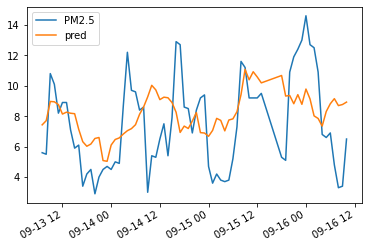

In [69]:
i = 504
print('province =',province)
h = y_train_scalers[province].inverse_transform(pred[i].numpy().reshape((-1,1)))
k = Y_test[province][i].copy()
k['pred'] = h
k.plot();

In [76]:
#model.save(f"./Models/{province}_{run_id}_chckpoint.h5")

# 4) Make submission

** SPEC : 720 timesteps, use 4 features ('PM2.5','WindDir','Wind Speed(km/h)','Temp(C)')

- **Bangkok** : `Models\Bangkok_run_2021_05_07-20_31_15_chckpoint.h5` (8.28)
- **Chanthaburi** : `Models\Chanthaburi_run_2021_05_08-12_58_02_chckpoint.h5` (5.47) 
- **Songkhla** : `Models\Songkhla_run_2021_05_08-19_56_09_chckpoint.h5` (6.06)
- **Kanchanaburi** : `Models\Kanchanaburi_run_2021_05_08-15_58_45_chckpoint.h5` (9.93)
- **Khon Kaen** : `Models\Khon Kaen_run_2021_05_07-23_38_36_chckpoint.h5` (10.75)
- **Chiang Mai** : `Models\Chiang Mai_run_2021_05_08-07_41_04_chckpoint.h5` (10.92)

In [11]:
models = {'Bangkok':'Models\Bangkok_run_2021_05_07-20_31_15_chckpoint.h5',
'Chanthaburi':'Models\Chanthaburi_run_2021_05_08-12_58_02_chckpoint.h5',
'Songkhla':'Models\Songkhla_run_2021_05_08-19_56_09_chckpoint.h5',
'Kanchanaburi':'Models\Kanchanaburi_run_2021_05_08-15_58_45_chckpoint.h5',
'Khon Kaen':'Models\Khon Kaen_run_2021_05_07-23_38_36_chckpoint.h5',
'Chiang Mai':'Models\Chiang Mai_run_2021_05_08-07_41_04_chckpoint.h5'}
grand = []
for province in ["Chanthaburi","Chiang Mai","Kanchanaburi","Bangkok","Khon Kaen","Songkhla"]:
    # Load model
    model = tf.keras.models.load_model(models[province])

    # Predict Test data
    x_eval = x_[province]['Test']

    pred = model(x_eval)

    prediction_1D = []

    for e in pred:
        prediction_1D.append(y_train_scalers[province].inverse_transform(e.numpy().reshape((-1,1))))

    prediction_1D = np.array(prediction_1D).reshape((-1,1))
    province_prediction = pd.DataFrame({'Predicted':prediction_1D.ravel()})

    grand.append(province_prediction)
    print(f"{province} done")

Chanthaburi done
Chiang Mai done
Kanchanaburi done
Bangkok done
Khon Kaen done
Songkhla done


In [12]:
# Save overall predictions
pd.concat(grand, ignore_index=True).rename_axis('Id').to_csv("./predictions/sub5.csv")
# Next step, use notebook TA provided to make submission file